# Modèle de langue et word embeddings

Les modèles de langue sont des modèles probabilistes d'une langue. A partir d'un corpus d'étude, ils apprennent la probabilité d'apparition d'un terme, ainsi que la probabilité qu'un terme suive un autre terme ou séquence de termes. Ainsi, les modèles de langues appartiennent à la famille des méthodes non-supervisées. Ils sont particulièrement adapté pour étudier la structure d'une langue, mais aussi adaptés à des tâches comme la reconnaissance de langue, l'analyse en partie du discours ou la génération de texte. 

Les premiers modèles de language reposent sur des méthodes statistiques. Plus récémment, les principaux modèles de langues tels que BERT ou GPT reposent sur les méthodes neuronales. Si ces derniers sont bien plus puissants et efficaces, les ressources informatiques nécessaires pour les faire tourner sont bien plus importantes.  

Dans ce cours, nous allons entraîner un modèle de langue statistique à l'aide de la librairie NLTK. 

In [1]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 294 kB 6.6 MB/s eta 0:00:01


## Modèle n-gramme

Un modèle n-gramme détermine le mot suivant le plus probable à partir d'une séquence n-1 de mots. Par exemple, un modèle bigramme déterminera la probabilité qu'un mot apparaisse en fonction du mot précédent, un trigramme à partir des deux mots précédents, et ainsi de suite. Un modèle unigramme lui ne repose que sur la probabilité d'apparition du mot dans le corpus, sans prendre en compte ce qui précéde. 

Exemple : 

p(There was heavy rainfall) = p(START, There, was, heavy, rainfall, END) = p(There|START)p(was|There)p(heavy|There was)p(rainfall|There was heavy)p(END|There was heavy rainfall)

Cependant, on ne peut réellement calculer la probabilité d'apparition d'une séquence aussi longue. On peut cependant calculer les probabilités d'apparition de chaque n-gramme précédents. Ainsi : 

p(There was heavy rainfall) = p(There|START)p(was|There)p(heavy|was)p(rainfall|heavy)p(END|rainfall)

Pour la génération de texte, les modèles à partir de trigrammes sont les plus intéressants. Cependant, la taille du modèle dépend de la tâche et du type de données traité.

### Préparer les données

Pour entraîner un modèle, il nous faut des liste de documents tokénisé. Ci-dessous, la variable "corpus" contient deux "phrases"

In [1]:
corpus = [
    ['a', 'b', 'c'],
    ['a', 'c', 'd', 'c', 'e', 'f']
    ]

NLTK permet de rapidement constituer des n-grammes. Ci-dessous, on produit des bigrammes à partir de nos séquences

In [4]:
from nltk.util import bigrams, trigrams

print('Bigrams')
for x in corpus:
    gram = list(bigrams(x))
    print(gram)

print('Trigrams')
for x in corpus:
    gram = list(trigrams(x))
    print(gram)

Bigrams
[('a', 'b'), ('b', 'c')]
[('a', 'c'), ('c', 'd'), ('d', 'c'), ('c', 'e'), ('e', 'f')]
Trigrams
[('a', 'b', 'c')]
[('a', 'c', 'd'), ('c', 'd', 'c'), ('d', 'c', 'e'), ('c', 'e', 'f')]


Il est important de distinguer l'occurrence d'un mot au sein de la phrase d'au début ou de la fin de phrase. Pour cela, on ajoute à la séquence deux caractères spéciaux, **s** et **/s** pour indiquer respectivement le début et la fin de phrase. 

In [5]:
from nltk.util import pad_sequence

for x in corpus:
    # l'argument n précise que l'on travaille sur des bigrammes
    seq = pad_sequence(x, n=2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>')
    print(list(seq))

['<s>', 'a', 'b', 'c', '</s>']
['<s>', 'a', 'c', 'd', 'c', 'e', 'f', '</s>']


La fonction "pad_both_ends" facilite l'emploi de "pad_sequence". Ci-dessous, une fonction pour prétraiter un corpus. Notez l'argument "gram_func" qui attend une fonction pour transformer la séquence en n-gramme (ex: fonction bigrams ou trigrams de NLTK). L'argument "n" doit correspondre au n-gramme donné.

In [6]:
from nltk.lm.preprocessing import pad_both_ends

for x in corpus:
    # l'argument n précise que l'on travaille sur des bigrammes
    seq = pad_both_ends(x, n=2)
    print(list(seq))

['<s>', 'a', 'b', 'c', '</s>']
['<s>', 'a', 'c', 'd', 'c', 'e', 'f', '</s>']


Afin d'avoir un modèle plus robuste, on peut l'entraîner sur des bigrammes et unigrammes à la fois. NLTK met à disposition la fonction "everygram", qui génère tous les n-grammes d'une séquence jusqu'à n.

In [7]:
from nltk.util import everygrams
n = 3
for x in corpus:
    # l'argument n précise que l'on travaille sur des bigrammes
    padded_seq = pad_both_ends(x, n=n)
    padded_grams = list(everygrams(padded_seq, max_len=n))
    print(padded_grams)

[('<s>',), ('<s>', '<s>'), ('<s>', '<s>', 'a'), ('<s>',), ('<s>', 'a'), ('<s>', 'a', 'b'), ('a',), ('a', 'b'), ('a', 'b', 'c'), ('b',), ('b', 'c'), ('b', 'c', '</s>'), ('c',), ('c', '</s>'), ('c', '</s>', '</s>'), ('</s>',), ('</s>', '</s>'), ('</s>',)]
[('<s>',), ('<s>', '<s>'), ('<s>', '<s>', 'a'), ('<s>',), ('<s>', 'a'), ('<s>', 'a', 'c'), ('a',), ('a', 'c'), ('a', 'c', 'd'), ('c',), ('c', 'd'), ('c', 'd', 'c'), ('d',), ('d', 'c'), ('d', 'c', 'e'), ('c',), ('c', 'e'), ('c', 'e', 'f'), ('e',), ('e', 'f'), ('e', 'f', '</s>'), ('f',), ('f', '</s>'), ('f', '</s>', '</s>'), ('</s>',), ('</s>', '</s>'), ('</s>',)]


Le modèle nécessite également un vocabulaire, c'est à dire d'un ensemble de mots connus du modèle. Les symboles de début et fin de phrases font partie de ce vocabulaire.

In [17]:
vocab = [token for sent in text for token in pad_both_ends(sent, n=2)]
vocab

['<s>', 'a', 'b', 'c', '</s>', '<s>', 'a', 'c', 'd', 'c', 'e', 'f', '</s>']

La fonction "padded_everygram_pipeline" nous permet de procéder à toutes ces étapes à l'aide d'une seule fonction

In [14]:
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 2
data, vocab = padded_everygram_pipeline(n, corpus)

In [12]:
for x in data:
    for y in x:
        print(y)

('<s>',)
('<s>', 'a')
('a',)
('a', 'b')
('b',)
('b', 'c')
('c',)
('c', '</s>')
('</s>',)
('<s>',)
('<s>', 'a')
('a',)
('a', 'c')
('c',)
('c', 'd')
('d',)
('d', 'c')
('c',)
('c', 'e')
('e',)
('e', 'f')
('f',)
('f', '</s>')
('</s>',)


In [13]:
for x in vocab:
    print(x)

<s>
a
b
c
</s>
<s>
a
c
d
c
e
f
</s>


## Entraîner le modèle

Nous pouvons désormais entraîner un modèle de langue. Nous allons entraîner un modèle MLE (Maximum Likelihood Estimator), qui compte la fréquence de chaque n-gramme puis les normalise pour que ces valeurs soient contenues entre 0 et 1. Pour plus de détails sur le fonction, voir Jurafsky. 

In [15]:
from nltk.lm import MLE
n = 2
lm = MLE(n)
# le vocabulaire est vide au départ
len(lm.vocab)

0

In [16]:
lm.fit(data, vocab)
len(lm.vocab)

9

In [17]:
text

NameError: name 'text' is not defined

In [18]:
print(lm.vocab.lookup(corpus[0]))
# les mots "aliens", "from", "Mars" ne sont pas contenus dans le vocabulaire. Ils sont donc associés à un token UNK
print(lm.vocab.lookup(["aliens", "from", "Mars"]))

('a', 'b', 'c')
('<UNK>', '<UNK>', '<UNK>')


In [19]:
# "a" apparait 2 fois dans le corpus
print('Compte de "a" ', lm.counts['a'])

# la probabilité que "a" apparaîsse dans le corpus
print(lm.score("a"))

# la probabilité que "b" apparaîsse en étant précédé de "a" == 1/2
print(lm.score("b", ["a"]))

# la probabilité que "d" apparaîsse en étant précédé de "a" == aucune
print(lm.score("d", ["a"]))

Compte de "a"  2
0.15384615384615385
0.5
0.0


## Evaluer un modèle de langue

Comme pour l'apprentissage supervisé, il nous faut des données de test pour évaluer un modèle. Cependant, le modèle de langue ne peut s'évaluer en terme de Précision, Rappel et F1, puisqu'il ne s'agit ni de classer, ni de retourner des informations. 

Pour évaluer un modèle de langue, on se sert de la mesure de **perplexité**, c'est à dire la probabilité ou la surprise que les données de test correspondent au modèle de langue. Elle repose sur la notion d'entropie, c'est-à-dire d'incertitude, dans la théorie de l'information. Plus la perplexité est basse (donc la probabilité est haute), et plus les données de test correspondent. Ainsi, pour évaluer un modèle de langue, il nous faut des extraits de langues qui sont représentatifs. 

La perplexité n'est pas la seule mesure pour évaluer un modèle de langue, mais s'en est une des principales. 

In [20]:
# ces données correspondent à notre modèle
test = [('a', 'b'), ('c', 'd')]
print(lm.perplexity(test))

# ces données ne correspondent pas à notre modèle: le modèle est inf(iniment) surpris
test = [('a', 'c'), ('b', 'd')]
print(lm.perplexity(test))

test = [('1', '2'), ('3', '4')]
print(lm.perplexity(test))

2.449489742783178
inf
inf


## Générer un texte

La force majeure des modèles de langues est de pouvoir générer des séquences de tokens (mots, POS tags...). On peut laisser le modèle tout générer seul ou bien lui donner une séquence de départ. De plus, on peut intégrer des règles pour modifier le processus de génération de texte. 

In [21]:
# génération simple
print(lm.generate(5, random_seed=42))

# génération en spécifiant le début de la séquence
print(lm.generate(5, text_seed=['<s>'],random_seed=42))

print(lm.generate(5, text_seed=['<s>', 'a'],random_seed=42))

['c', '</s>', '<s>', 'a', 'c']
['a', 'b', 'c', '</s>', 'c']
['c', '</s>', '<s>', 'a', 'c']


## Smoothing

Pour le moment, notre modèle n'est capable d'assigner une probabilité à une séquence seulement s'il l'a vu dans le corpus d'étude. Cependant, un caractère peut être présent dans le vocabulaire, mais apparaître dans un nouveau contexte dans un autre corpus. Un caractère peut également ne pas apparaître du tout dans le vocabulaire du modèle. Dans un tel cas, ce caractère aura une probabilité nulle qui lui sera assignée. Pour éviter cela, il faut procéder au **smoothing**. Les principaux algorithmes de smoothing sont :

* Laplace (add-one) smoothing
* add-k smoothing
* stupid backoff
* Kneser-Ney smoothing

Une autre possibilité est d'employer l'**interpolation** ou le **backoff**

* backoff : si une séquence n'existe pas, on réduit cette séquence jusqu'à en trouver une connue du modèle
* interpolation : on fait la somme de la probabilité associée à chaque n-gramme contenu dans la séquence (unigrame + bigramme + ... + n-gramme)

In [22]:
from nltk.lm import Laplace
n = 2

data, vocab = padded_everygram_pipeline(n, corpus)

lm = Laplace(n)
lm.fit(data, vocab)

In [23]:
# ces données correspondent à notre modèle
test = [('a', 'b'), ('c', 'd')]
print(lm.perplexity(test))

# ces données ne correspondent pas à notre modèle: le modèle est inf(iniment) surpris
test = [('a', 'c'), ('b', 'd')]
print(lm.perplexity(test))

test = [('1', '2'), ('3', '4')]
print(lm.perplexity(test))

5.744562646538029
7.416198487095664
9.000000000000002


In [24]:
from nltk.lm import AbsoluteDiscountingInterpolated
n = 2

data, vocab = padded_everygram_pipeline(n, corpus)

lm = AbsoluteDiscountingInterpolated(order=n)
lm.fit(data, vocab)

In [25]:
# ces données correspondent à notre modèle
test = [('a', 'b'), ('c', 'd')]
print(lm.perplexity(test))

# ces données ne correspondent pas à notre modèle: le modèle est inf(iniment) surpris
test = [('a', 'c'), ('b', 'd')]
print(lm.perplexity(test))

test = [('1', '2'), ('3', '4')]
print(lm.perplexity(test))

6.2300398978808
7.62564998111037
inf


## Ressources : 

Pour plus de détails dans les calculs de probabilités et la construction mathématique des modèles de langue : 
* Documentation NLTK : https://www.nltk.org/api/nltk.lm.html
* Jurafsky et al : https://web.stanford.edu/~jurafsky/slp3/3.pdf

# Word embeddings

## Les inconvénients de la méthode sac de mots

Dans les cours précédents, nous avons utilisé la méthode du sac de mots afin d'encoder des données textuelles afin de pouvoir les donner en entrée à nos algorithmes. Cette méthode à été une des premières utilisée dans le domaine du TAL et du Machine Learning. En encodant chaque token par leur fréquence d'apparition ou par leur poids par rapport aux documents du corpus (Tf-idf), cette méthode permet de constituer des vecteurs de mots, qui sont ensuite utilisés comme données d'entraînement à nos modèles.

Cependant, comme nous l'avons déjà vu, cette méthode d'encodage du texte et donc cette méthode de production des vecteurs posent plusieurs problèmes du point de vue informatique et linguistique:

* Pour chaque samples de notre dataset, on créé un vecteur dont le nombre de dimensions est égal à la taille de notre vocabulaire. Ces vecteurs sont donc généralement composés de plusieurs dizaines de millier de dimensions, ce qui est très coûteux en terme de calcul.

* De plus, pour chaque sample, seuls une très petite portion de notre vocabulaire y est présent. Ainsi, peut importe la méthode d'encodage que l'on choisit, le vecteur de mots sera essentiellement composé de zéros. L'essentielle des dimensions de notre vecteur ne sont donc pas pertinentes pour la compréhension du sample traité.

* Le sac de mot ne conserve aucune information sur la structure du texte ni la syntaxe de la phrase. Or, un même vocabulaire peut prendre un sens très différent selon l'ordre dans lequel il est utilisé. 

* La valeur que prend un mot dépend de son encodage, c'est-à-dire soit de son nombre d'occurrences dans le corpus, soit de son poids par rapport aux autres termes dans le document et dans le corpus. Ainsi, il n'a pas de vraie valeur sémantique.

Ainsi il est évident que la méthode sac de mots n'est pas suffisante si l'on souhaite améliorer les modèles existants ou réduire la puissance de calcul demandée.

In [ ]:
doc_1 = [0, 0, 10, ...]

## Word embedings

Les Words Embeddings sont très différents des sac de mots: Un Word Embeddings peut se comparer à un dictionnaire pour lequel chaque clé est un mot et chaque valeur est un vecteur représentant ce mot. La taille de ces vecteurs est de l'ordre de la centaine, et sont généralement constitués de 50, 100, 300 ou 500 dimensions, ce qui est extrêmement réduit par rapport au vecteur de vocabulaire du sac de mots. 

Ci-dessous, un exemple de faux Word Embbedings:

``
we = {
    "chat": [0.33, 0.5, 0.86, 0.77, 0.23],
    "le" : [0.21, 1, 0.93, 0.54, 0.64],
    "rat" : [0.96, 0.16, 0.98, 0.88, 0.26],
    "mange" : [0.63, 0.97, 0.4, 0.32, 0.43]
}
``

En utilisant la méthode de sac de mots, on encoderait la phrase ``Le chat mange le rat`` avec un vecteur de la taille du vocabulaire et dans lequel on indiquerait la présence (one-hot encoding) oule nombre d'occurrences de chaque mot. A l'inverse en encodant cette phrases avec des Word Embeddings, chaque mot serait représenté par le vecteur qui lui est associé:

``[
    [0.21, 1, 0.93, 0.54, 0.64], ==> le
    [0.33, 0.5, 0.86, 0.77, 0.23], ==> chat
    [0.63, 0.97, 0.4, 0.32, 0.43], ==> mange
    [0.21, 1, 0.93, 0.54, 0.64], ==> le
    [0.96, 0.16, 0.98, 0.88, 0.26] ==> rat
]``

### Note

Le terme Word Embedding fait référence au fait de représenter un mot sous forme de vecteur. Ainsi, un vecteur dans lequel on indique la fréquence d'apparition d'un mot dans un contexte donné ou bien son poids par rapport au corpus est un Word Embedding. Cependant, on distingue ces méthodes de celles où ces vecteurs sont appris de manière automatique et qui comporte une plus grande information sémantique: ce sont ces méthodes (Word2Vec, GloVe, fastText, ...) que l'on englobe communément dans le terme "Word Embeddings"

## Word2Vec

Le terme Word Embeddings est réellement devenu proéminent dans le domaine du TAL et du Machine Learning grâce l'algorithme ``Word2Vec``, développé par Mikolov et al (2013). A son apparition, Word2Vec a totalement chamboulé le domaine du TAL: en représentant les mots dans un espace vectorielle, il a permis de traiter l'aspect sémantique d'un vocabulaire. Ainsi, des performances jamais obtenues jusque là ont pu être atteinte, tandis que de nouveaux traitements linguistiques s'ouvraient.

<img src='data/img/wordemb.png'>


Ref: https://medium.com/@hari4om/word-embedding-d816f643140

<img src='data/img/wordemb2.png'>

## Sémantique, logique et mathématique

Un intérêt majeur de représenter le vocabulaire sous forme de vecteur est que cela permet de réaliser des opérations logiques au travers d'opérations mathématiques. 

### Calcul de similarité

Tout d'abord, cela permet pour un ou plusieurs mots donnés d'en trouver les plus similaires. Ci-dessous on peut voir que les mots "cat" et "kitten" sont très proches. Mathématiquement, on peut calculer la similarité entre ces deux vecteurs (donc deux mots) en calculant leur similarité cosinus.

<img src='data/img/cat_kitten.png'>

### Analogie

Un autre aspect très important des Word Embeddings est qu'il permet de traiter l'analogie entre différents termes. Ci-dessous une analogie très célèbre dans le contexte des Word Embeddings:

``Le mot 'homme' est au mot 'femme' ce que le mot 'roi' est au mot 'reine``

Comme on peut le voir sur l'image ci-dessous, la relation entre les points (man - woman) et (king - queen) sont similaires et situés relativement proches les uns des autres.

<img src='data/img/king_queen.png'>


Grâce aux vecteurs, on peut exprimer l'analogie ci-dessus de manière mathématique avec des additions et des soustractions:

`` (roi - homme) + femme = reine``

### CBOW et SkipGram

Contrairement aux travaux précédents, qui se basaient sur des matrices de co-occurrences de mots pour générer des vecteurs, Word2Vec consiste à entraîner un réseau de neurones à partir duquel on génère les vecteurs de mots. Le nombre de dimensions des vecteurs produits par cette méthode est de lors d'une à plusieurs centaines, ce qui est considérablement moins que les dizaines de millier de dimensions avec le sac de mots.

``Word2Vec`` se divise en deux méthodes opposées d'apprentissage: ``CBOW (Continuous Bag of Words)`` et ``SkipGram``. 

<img src="data/img/cbow_skipgram.png">


* CBOW: le modèle doit prédire un mot en ayant comme donnée d'entrée son contexte direct, qui est constitué d'une fenêtre plus ou moins grande de mots

<img src='data/img/bow.gif'>

* Skip-gram: Le modèle prend en entrée un mot et doit prédire son contexte. C'est l'opposé de CBOW.

<img src='data/img/skip.gif'>


Lors de l'entraînement, le modèle apprend des paramètres de manière itérative qui lui permette de prédire (correctement ou non) les mots cibles. Ce sont ces paramètres qui vont constituer les vecteus de mots, et ainsi, ce sont ces paramètres et pas tant le modèle en lui-même que l'on va conserver.

### Avantages et inconvénients de chaque méthode

* Skip-gram est plus adapté aux petits corpus. De plus, elle représente mieux les mots relativement peu fréquents dans le corpus. Cependant, son temps d'entraînement est très long.
* CBOW est plus adapté aux grands corpus. Il généralise mieux que Skip-gram, et représente donc mieux les mots plutôts fréquents. De plus, il est relativement rapide à entraîner. Cependant, il peut donner de mauvais résultats sur un corpus trop petit et les poids obtenus ne seront pas autant spécialisés qu'avec Skip-gram.


## Entraîner votre propre modèle

### Charger les données

Nous allons entraîner notre premier modèle sur la portion d'analyse de sentiments du ``amazon_reviews`` que nous avons sauvegardé précédemment. Cette portion se trouve dans le dossier ``data/multiclass`` de ce notebook.

In [26]:
import pandas as pd
df = pd.read_csv('data/multiclass/as_train.csv')
corpus = df.texts
corpus.head()

0    A déconseiller - Article n'a fonctionné qu'une...
1    Si vous voulez être déçu achetez le produit ! ...
2    Écran de mauvaise qualité, car il s'use en peu...
3    Cet engin ne sert à rien les sons sont pourris...
4    Très beau produit mais la grue n'a pas fonctio...
Name: texts, dtype: object

Gensim attend que les données d'entrées soit au minimum tokenizées. Pour l'exemple ci-dessous, nous nous contenterons de diviser les phrases au niveau des espaces, mais il est recommandé de prétraiter vos données de la même manière que précédemment, c'est à dire d'utiliser un vrai tokenizer, de supprimer les mots-vides, de transformer le texte en minuscule, etc.

In [30]:
!python -m spacy download fr_core_news_sm

Traceback (most recent call last):
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/runpy.py", line 147, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/site-packages/spacy/__init__.py", line 15, in <module>
    from .cli.info import info  # noqa: F401
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/site-packages/spacy/cli/__init__.py", line 3, in <module>
    from ._util import app, setup_cli  # noqa: F401
  File "/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/site-packages/spacy/cli/_util.py", line 9, in <module>
 

In [29]:
import spacy
nlp = spacy.load('fr_core_news_sm')

ImportError: cannot import name 'get_terminal_size' from 'click.termui' (/Users/nicolasgutehrle/opt/anaconda3/envs/cours/lib/python3.9/site-packages/click/termui.py)

In [4]:
docs = nlp.pipe(corpus[:5000])
train = [] # creer nouvelle liste qui servir de corpus tokenizé
for doc in docs:
    filtered_doc = [] # doc tokenizé
    for token in doc:
        if token.is_stop:
            pass
        elif token.is_punct:
            pass
        else:
            filtered_doc.append(token.lemma_) # si token est bon, on l'ajoute a la liste
            
    train.append(filtered_doc) # on ajoute le doc tokenizé au nouveau corpus

## Gensim

``scikit-learn`` ne permet pas d'utiliser ou d'entraîner des Words Embeddings. Pour cela, nous allons utiliser ``gensim``, une librairie de TAL spécialisée dans les tâches non-supervisées (topic modelling, word embeddings, ...). 

Elle propose également une implémentation de Word2Vec ainsi que d'autres algorithmes similaires tels que GloVe et FastText (que nous présenterons plus tard). Elle sert également d'API permettant d'utiliser ces trois algorithmes de la même manière.

In [6]:
from gensim.models.word2vec import Word2Vec # on importe la classe Word2Vec
# crééer le modèle et lui donner les données lance l'entraînement
model = Word2Vec(sentences = train)

Par défaut, le modèle Word2Vec de Gensim créé des vecteurs à 100 dimensions et utilise la méthode CBOW. De plus, il ne considère par défaut que les mots occurrants au moins 5 fois dans le corpus et utilie une fenêtre de 5 mots de contexte lors de l'entraînement.

In [11]:
model.wv.vocab

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [8]:
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(i, word)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [24]:
len(model.wv.vocab)

1766

Dans Gensim, les vecteurs sont contenus dans la propriété ``wv`` de votre modèle. Pour obtenir l vecteur d'un mot, il suffit de le donner en index, comme pour un dictionnaire:

In [12]:
model.wv['article']

array([-0.25532645,  0.40520772,  0.08530292,  0.08051319,  0.1792276 ,
       -0.6952582 ,  0.16616455,  0.8068265 , -0.32048878, -0.246494  ,
       -0.24522711, -0.6452503 , -0.07073019,  0.12570128,  0.03112432,
       -0.3486686 , -0.04763675, -0.47627515, -0.07456362, -0.6311179 ,
        0.17140576,  0.27084276,  0.15460801, -0.25665915, -0.11724535,
       -0.05270885, -0.38669258, -0.36303726, -0.33437285, -0.08058538,
        0.30668992,  0.0790379 ,  0.12327613, -0.09210966, -0.27978987,
        0.46599925,  0.01484592, -0.49812692, -0.20823085, -0.8380023 ,
        0.17366855, -0.2844147 ,  0.02119729, -0.01766261,  0.27059153,
       -0.11366633, -0.22479628, -0.11822856,  0.2405547 ,  0.16269894,
        0.18236665, -0.33445388, -0.11590739, -0.01788492, -0.00612189,
        0.35585123,  0.29613703,  0.04808021, -0.44746116,  0.11884031,
        0.11987   ,  0.12157893, -0.00322383,  0.02806825, -0.51337767,
        0.26281565,  0.11444645,  0.2360296 , -0.4522114 ,  0.52

In [26]:
model.wv['article'].shape

(100,)

## Trouver le mot le plus similaire

In [13]:
model.wv.most_similar('recommande')

[('achat', 0.9996308088302612),
 ('tenir', 0.9996005296707153),
 ('acheter', 0.9995850324630737),
 ('déçu', 0.9995845556259155),
 ('bref', 0.9995772838592529),
 ('inutilisable', 0.9995712041854858),
 ('niveau', 0.9995613694190979),
 ('bon', 0.9995589852333069),
 ('fonctionne', 0.9995576739311218),
 ('plastique', 0.999556303024292)]

### Calculer la similarité entre deux mots

In [14]:
print("Distance 'article' - 'acheter' :", model.wv.distance('article', 'acheter'))
print("Distance 'plastique' - 'bref' :", model.wv.distance('plastique', 'bref'))

Distance 'article' - 'acheter' : 0.0017984509468078613
Distance 'plastique' - 'bref' : 0.00031310319900512695


### Calculer la similarité entre deux vecteurs

In [31]:
article = model.wv['article']
produit = model.wv['produit']
bref = model.wv['bref']

print("Distance 'article' - 'produit' :", model.wv.cosine_similarities(article, [produit]))
print("Distance 'article' - 'canard' :", model.wv.cosine_similarities(article, [bref]))

Distance 'article' - 'produit' : [0.9998901]
Distance 'article' - 'canard' : [0.9998109]


### Identifier les mots les plus similaires

In [32]:
# identifie les mots les plus similaire d'un mot
model.wv.similar_by_word('article')

[('Amazon', 0.9999183416366577),
 ('produit', 0.9998900294303894),
 ('devoir', 0.9998878240585327),
 ('faire', 0.9998875260353088),
 ('amazon', 0.9998860359191895),
 ('livre', 0.9998849630355835),
 ('vendeur', 0.9998847246170044),
 ('renvoyer', 0.9998829364776611),
 ('commande', 0.9998828172683716),
 ('rembourser', 0.9998816847801208)]

In [33]:
# identifie le mot le plus similaires de la liste par rapport
# a un autre mot
list_word = ['produit', 'Amazon', 'bref']
model.wv.most_similar_to_given('article', list_word)

'Amazon'

In [35]:
# identifie les mots les plus similaires en se basant sur deux listes:
# une liste positive et une liste négative
# retourne les mots les plus similaires à un champ lexical donné par la liste positive
# en faisant en sorte de s'éloigner du champ lexical des mots négatifs
pos = ['objet', 'produit']
neg = ['Amazon']
model.wv.most_similar(pos, neg)


[('appareil', 0.9997512102127075),
 ('servir', 0.9997507333755493),
 ('petit', 0.9997495412826538),
 ('inutilisable', 0.9997475743293762),
 ('fonctionner', 0.9997460246086121),
 ('décevant', 0.9997374415397644),
 ('y', 0.9997371435165405),
 ('acheter', 0.9997363090515137),
 ('chose', 0.999734103679657),
 ('film', 0.9997307062149048)]

In [ ]:
!pip install gensim

### Identifier un intrus 

In [37]:
list_word = ['article', 'bref', 'produit', 'objet']
model.wv.doesnt_match(list_word)

'objet'

### Identifier un mot plus proche

In [38]:
model.wv.words_closer_than('article', 'objet')

['produit',
 'déçu',
 'acheter',
 'colis',
 '2',
 'jour',
 'faire',
 'vendeur',
 'y',
 'mettre',
 'fois',
 'impossible',
 'arriver',
 'commander',
 'vraiment',
 'bon',
 'commande',
 'petit',
 'prix',
 'achat',
 'recommande',
 'livrer',
 '3',
 'livraison',
 'l',
 'Amazon',
 'remboursement',
 'dommage',
 'n',
 'devoir',
 'vouloir',
 'j',
 'utiliser',
 'fonctionner',
 'photo',
 'problème',
 'renvoyer',
 'décevoir',
 'voir',
 'semaine',
 'mal',
 'téléphone',
 'd',
 'falloir',
 'rembourser',
 'attendre',
 'Bonjour',
 'temps',
 'cassé',
 'euro',
 'livre',
 'verre',
 '4',
 'servir',
 'plastique',
 'savoir',
 'emballage',
 'appareil',
 'coup',
 'demande',
 'c',
 'éviter',
 'bref',
 'prendre',
 'correspondre',
 'réponse',
 'avoir',
 'passer',
 'inutilisable',
 'taille',
 'pouvoir',
 '10',
 'amazon',
 'envoyer',
 'commentaire',
 'niveau',
 'carton',
 'grand',
 'Article',
 'couleur',
 '5',
 'indiquer',
 'marche',
 'retourner',
 'pourtant',
 'part',
 'demander',
 'gros',
 'venir',
 'heure',
 'cade

### Sauvegarder le modèle sur le disque

In [135]:
import os
savepath = 'data/w2v_model'
if not os.path.exists(savepath):
    os.mkdir(savepath)
model.save(f"{savepath}/amazon_vec.bin")

## Visualiser des Word Embeddings

L'entraînement d'un modèle comme Word2Vec étant non-supervisé, il peut être utile de visualiser les résultats pour se rendre compte de la qualité. Cependant, les Word Embeddings ont certes bien moins de dimensions que les sacs de mots, il n'en reste pas moins qu'ils en comportent souvent plusieurs centaines. 

Ainsi, pour les visualiser, il est nécessaire de réduire le nombre de dimensions sans que cela n'en change la valeur. Pour cela, on peut faire appel à des techniques de réduction de dimensions telles que PCA.

In [44]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model[model.wv.vocab]
pca = PCA(n_components=2)
results = pca.fit_transform(X)
results.shape

<ipython-input-44-8d529525dddb>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


(32528, 2)

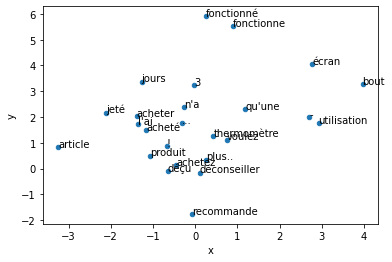

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df = pd.DataFrame(results, columns=['x', 'y'], index = model.wv.vocab)
data = df.iloc[:25]

data.plot('x', 'y', kind='scatter', ax=ax)

for k, v in data.iterrows():
    ax.annotate(k, v)


## Autres méthodes de Word Embeddings

### GloVe

GloVe est un algorithme créé par Penington et al en 2014 faisant suite à Word2Vec tout en étant très différent. Pour un corpus donné, GloVe constitue un vocabulaire ainsi qu'une liste de contexte. Il calcule ensuite la matrice de co-occurrences entre chaque mot du vocabulaire et un contexte donné. La taille du vocabulaire ainsi que des contextes possibles produisent une matrice gigantesque: GloVe utilise donc ensuite différentes méthodes pour réduire le nombre de dimensions de cette matrice, tout en conservant les informations produites.

Ainsi, GloVe se distingue de Word2Vec par deux aspects: tout d'abord il repose sur des méthodes statistiques et sur des matrices de co-occurrences plutôt que sur l'entraînement d'un réseau de neurones, et enfin les vecteurs produits ne sont pas de simple vecteurs one-hot, mais des vecteurs de co-occurrences mots-contexte, qui comportent beaucoup plus de valeur sémantique. Contrairement à Word2Vec, GloVe produit une matrice de co-occurrences pour l'ensemble du corpus, tandis que Word2Vec ne traite le contexte que sur une fenêtre donnée. Bien que produire cette matrice peut prendre du temps, l'opération n'est réalisée qu'une seule fois, contrairement à Word2Vec.

En cela, la méthode GloVe produit de meilleurs Word Embeddings et ce plus rapidement.

### Exemple de matrice de co-occurrences de mots

Ref : https://www.linkedin.com/pulse/word2vec-co-occurrence-words-shamane-siriwardhana/

<img src='data/img/coocc_matrix.jpeg'>



### fastText

Bien que Word2Vec et GloVe permettent de produire d'excellents Word Embeddings, ils ont en commun un défaut majeur: ils ne peuvent produire ou donner un vecteur d'un mot qui n'est pas contenu dans leur vocabulaire. En effet lors de l'entraînement, ces deux modèles constituent un vocabulaire pour lequel ils calculent les vecteurs associés à chaque mot. Cependant, si l'on devait utiliser un Word Embeddings produit de cette façon sur un corpus comportant de nouveaux mots, on ne pourrait obtenir les vecteurs pour ces mots: il faudra donc les ignorer. 

FastText est un algorithme produit par FAIR (Facebook's AI Research) en réponse à cette problématique en 2015. Il repose sur la même méthode que Word2Vec (plus précisémment la méthode Skip-gram). Cependant, contrairement à Word2Vec et GloVe, il ne constitue pas un vocabulaire par unité lexicale mais par sous-unités. Ainsi, au moment de produire le vecteur d'un mot, fastText produit déjà les vecteurs associés à chaque sous-unité composant ce nom, puis les combine. Ainsi pour chaque mot inconnu dans un nouveau corpus, fastText en produira un vecteur en le décomposant automatiquement en sous-unité qu'il connaît. 

### Exemple des sous-unités lexicales

Ref : https://amitness.com/2020/06/fasttext-embeddings/

<img src='data/img/fasttext.png'>

Un autre avantage énorme de fastText est que l'équipe de FAIR a déjà traité près de 300 langues différentes et a produit des Word Embedding pour chaque d'elle. Ceci vous permet donc d'accéder facilement aux Word Embeddings et de les incorporer à votre projet.

## Autres algorithmes de Word Embeddings

* ELMo
* Pointcare Embeddings
* Probabilistic FastText

## Utiliser des modèles pré-entraînés

De part l'utilisation de réseau de neurones, on considère que Word2Vec et les autres algorithmes similaires font partie du Deep Learning plutôt que du Machine Learning. Les réseaux de neurones ont permis de faire des progrès considérables dans le traitement des données. 

Cependant, ces progrès se sont fait au coût de modèles très lourds en terme d'espace disque et mémoire, mais aussi au coût de très nombreuses heures d'entraînement. 

Ainsi dans la communauté de Deep Learning, il est commun de partager son modèle une fois que celui-ci a terminé son entraînement et qu'il y a obtenu des résultats satisfaisants. Ceci est intéréssant pour différentes raisons:

* Tout d'abord, cela répond à la difficulté de trouver assez de données pour entraîner un modèle similaire. Si quelqu'un a entraîné un modèle sur un problème similaire au votre, il est logique d'utiliser son modèle plutôt que d'entraîner soi-même un modèle avec moins de données, au risque donc d'obtenir de moins bons résultats.

* Entraîner un bon réseau de neurones demande d'avoir une très grande quantité de données. Cependant, la puissance de calcul demandées pour traiter une telle masse de données est bien plus importante que pour les algorithmes en Machine Learning. Ainsi, peut d'ordinateur personnels sont en mesure d'entraîner de bons réseaux sans y passer des jours, voir des semaines. Utiliser un modèle pré-entraîné vous permet d'accéder à ces réseaux sans y invester à nouveau autant de temps.

* Un modèle pré-entraîné peut servir de base à votre nouveau modèle. En effet, de manière simpliste, les modèles en Deep Learning peut continuer à apprendre même lorsque leur entraînement est terminé. Ainsi, des modèles peuvent avoir été entraînés sur des données très générales (ex: Wikipédia). Ces modèles sont souvents très grands et ne sont pas très efficaces. Cependant, vous pouvez les utiliser et les affiner sur vos propres données, vous permettant ainsi d'obtenir de meilleurs résultats que si vous aviez créer un modèle depuis le début. On parle alors de **transfer learning**. Nous reviendrons plus tard sur ces notions

## Exemple de Word Embeddings

Avant de générer par nous-mêmes des Words Embeddings, nous allons en charger un déjà entraîné afin d'en voir les différents intérêts. Gensim propose certains embeddings déjà prêts que l'on peut directement télécharger, tel que celui entraîné sur le Google News Dataset (environ 3 millions de mots). 

Attention, ce modèle pèse près de 2gb et peut prendre du temps à télécharger:

In [1]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[=-------------------------------------------------] 2.2% 36.0/1662.8MB downloaded

KeyboardInterrupt: 

# Références

GloVe : https://nlp.stanford.edu/projects/glove/

fastText : https://fasttext.cc/

Résumés des méthodes de Word Embeddings : http://hunterheidenreich.com/blog/intro-to-word-embeddings/

Post de blog sur la différence Word2Vec / fastText : https://amitness.com/2020/06/fasttext-embeddings/

https://iksinc.online/tag/continuous-bag-of-words-cbow/

https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314

https://www.analyticsvidhya.com/blog/2020/07/neural-networks-from-scratch-in-python-and-r/

https://towardsdatascience.com/understanding-neural-networks-19020b758230

http://jalammar.github.io/illustrated-word2vec/

https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

https://kavita-ganesan.com/comparison-between-cbow-skipgram-subword/#.X0z4CxmxVhE